<H1>Try Two of Movie Review Sentiment Analysis<H1>

<H2>Summary</H2>
Note, this attempt at sentiment analysis is version 2 of our work.  The first version described what we are doing so wee will not repeat it here.

So the below code is just the library imports and the code in the cell below that is just defining a funciton to read in the input files.

In [2]:
#imports
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import pandas as pd
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import time
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from nltk.stem.snowball import SnowballStemmer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [63]:
def LoadData(trainOrTest, lowerCase):    
    lines=[]
    if trainOrTest == 'train':
        dfTxt = pd.read_csv('moviesentiment/train.tsv', sep = '\t')
    elif trainOrTest == 'test':
        dfTxt = pd.read_csv('moviesentiment/test.tsv', sep = '\t')
    else:
        return 'error'    
    
    # we don't know the state of the imported data...shuffle to make sure it is random
    if trainOrTest == 'train':
        dfTxt = shuffle(dfTxt, random_state=42)
    lines = dfTxt.Phrase
    #lowercase the text to reduce size of matrices to improve memory and run times (hopefully) as we will have less unique strings
    if lowerCase:
        lines = [line.lower() for line in lines]
    
    if trainOrTest == 'train':
        sents = dfTxt.Sentiment
    else:
        sents = None
    return dfTxt, lines, sents

<H2>Stem Words</H2>
We will do some lemmatization to get down to the root words.  Note we want to do this before the next section, marking negative words as once we indentify in the text words that are negative with a "_neg" suffix, lemmatization won't work.


In [4]:
def StemWords(stemChoice, lines):
    if stemChoice == 'porter':
        stemmer = nltk.PorterStemmer()        
    elif stemChoice == 'snowball':
        stemmer = SnowballStemmer("english" )        
    else:
        return 'error'    
    stemmedLines = [([stemmer.stem(s) for s in line.split()]) for line in lines]
    lines = ([' '.join(tup) for tup in stemmedLines])
    return lines

<H2>Mark Negative Words</H2>
Find words that are used in negative phrases, e.g., This is not a good movie.  The words between the negative word, 'not', and the end of the sentence are marked as negative, i.e., a_neg, good_neg, movie_neg.  Hopefully this will identify some common words that are used in negative phrases to identify the degree of negative, while also just plainly flagging sentences that are negative.

In [5]:
# mark negative words 
def MarkNegative(lines):
    lines = [mark_negation(line.split()) for line in lines]
    lines = ([' '.join(tup) for tup in lines])
    lines = pd.Series( (line for line in lines) )
    return lines



<H2>Create Train and Test Sets of Data</H2>

In [6]:
#choose porter as stemmer first
def CreateTrainTestData(lines, trainSize, testSize):
    size = trainSize -testSize
    trainLines = lines[:size]
    testLines = lines[size:size+testSize]
    trainSents = sents[:size]
    testSents = sents[size:size+testSize]
    return trainLines, testLines, trainSents, testSents

In [7]:
dfTxt, lines, sents = LoadData('train')
allLines = StemWords('porter', lines)
allLines = MarkNegative(allLines)
trainLines, testLines, trainSents, testSents = CreateTrainTestData(allLines, len(allLines), 5000)


<H2>Data Examination</H2>

We see that the majority of the data is classified as 2 (or neutral) sentiment.  So the data is "unbalanced".  This will play into some of the items we try in developing a classifier as we proceed.

<Figure size 576x432 with 0 Axes>

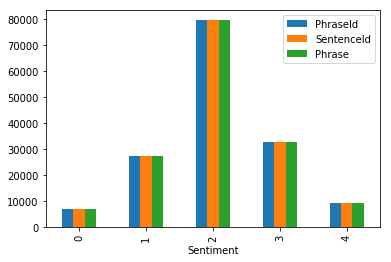

In [8]:
fig = plt.figure(figsize=(8,6))
dfTxt.groupby('Sentiment').count().plot.bar(ylim=0)
plt.show();

<H2>Create PipeLine</H2>

<H3>Create Features</H3>
Use CountVectorizer to create features out of all the words in the text, basically a sparse matrix of term -> frequencies.  

<H3>Use TfidfTransformer</H3>
So question becomes, does this transformation into term frequencies, which is based on Inverse Document Frequency (IDF).  This is supposed to reduce the weight from longer documents as opposed to shorter documents, but based on how our text is constructed (each document is at most a sentence), not sure how much this will help.

<H3>Train Using Multinomial Naive Bayes</H3>

Note, the starting params are nothing special, we will examine how to tune those later.

In [9]:
clfNB = Pipeline([('vect', CountVectorizer(max_df = .75, ngram_range = (1,1), stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha = 0.001)),
])
# print trainLines
# print len(trainSents)
# print len(testSents)
clfNB = clfNB.fit(trainLines, trainSents)


predicted = clfNB.predict(testLines)
print np.mean(predicted == testSents)
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))

0.6002
             precision    recall  f1-score   support

          0       0.49      0.19      0.28       231
          1       0.54      0.35      0.43       901
          2       0.63      0.86      0.73      2553
          3       0.52      0.39      0.44      1045
          4       0.53      0.17      0.26       270

avg / total       0.58      0.60      0.57      5000



<H2>Grid Search</H2>
Let's use grid search and try to optimize hyperparameters.  

Note, commented out so reruns don't spend an exceptional long time running this...note, best params are in comments below.  During development we used subsets of the data for initial tuning, but used complete data for my final tuning which takes quite a long time to execute



In [31]:
# parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
#                'vect__max_df': (0.3, 0.4,0.5,0.6,0.7,0.8),               
#                'tfidf__use_idf': (True, False),
#                'clf__alpha': (.1, .01, .001),}
# gs = GridSearchCV(clf, parameters, n_jobs=6)
# gs = gs.fit(trainLines, trainSents)


In [32]:
# print gs.best_score_
# gs.best_params_


#Best Results
# {'clf__alpha': 0.1,
#  'tfidf__use_idf': False,
#  'vect__max_df': 0.4,
#  'vect__ngram_range': (1, 3)}

0.6354627300410433


{'clf__alpha': 0.1,
 'tfidf__use_idf': False,
 'vect__max_df': 0.3,
 'vect__ngram_range': (1, 3)}

<H2>Update to use optimized params</H2>

We see we went up in accuracy over 5%

In [10]:
clfNB = Pipeline([('vect', CountVectorizer(max_df = 0.3, ngram_range = (1,3), stop_words='english')),
                     ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clf', MultinomialNB(alpha = 0.1)),
])
clfNB = clfNB.fit(trainLines, trainSents)

predicted = clfNB.predict(testLines)
print np.mean(predicted == testSents)
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))

0.6514
             precision    recall  f1-score   support

          0       0.48      0.43      0.45       231
          1       0.58      0.51      0.54       901
          2       0.73      0.80      0.76      2553
          3       0.56      0.53      0.54      1045
          4       0.50      0.39      0.44       270

avg / total       0.64      0.65      0.65      5000



<H2>Try a Different Tool</H2>

Try using Stochastic Gradient Descent.  We will use the same params for the CountVectorizer and TfidfTransformer as we did above, and then after our initial run, we will try to tune them.


In [11]:
# works  worse than naive bayes at this point
clf_SGD = Pipeline([('vect', CountVectorizer(max_df = 0.5, ngram_range= (1,2), stop_words='english')),
                     ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clf_SGD', SGDClassifier(alpha = 0.0001, penalty = 'l2',  max_iter=1000, tol = .0001, random_state=42)),
])
clf_SGD = clf_SGD.fit(trainLines, trainSents)

predicted = clf_SGD.predict(testLines)
print(np.mean(predicted == testSents))
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))


0.563
             precision    recall  f1-score   support

          0       0.59      0.10      0.18       231
          1       0.54      0.10      0.16       901
          2       0.56      0.96      0.71      2553
          3       0.54      0.21      0.30      1045
          4       0.67      0.12      0.21       270

avg / total       0.56      0.56      0.48      5000



<H2>GridSearch for SGD</H2>

Note, again, commented out, so reruns don't take exceptional amounts of time.  Best params are in comments.

In [42]:
# parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
#                'vect__max_df': (0.2, 0.3,0.4,0.5,0.6),  
#                'tfidf__use_idf': (True, False),
#                'clf_SGD__alpha': (.0001, .00001),
#                'clf_SGD__penalty': ('l2', 'elasticnet'),} 
          

# gs_SGD = GridSearchCV(clf_SGD, parameters, n_jobs=6)
# gs_SGD = gs_SGD.fit(trainLines, trainSents)              
 

# # Best Params:
# {'clf_SGD__alpha': 1e-05,
#  'clf_SGD__penalty': 'l2',
#  'tfidf__use_idf': False,
#  'vect__max_df': 0.2,
#  'vect__ngram_range': (1, 3)}

In [43]:
# print gs_SGD.best_score_
#gs_SGD.best_params_

0.646491460346882


{'clf_SGD__alpha': 1e-05,
 'clf_SGD__penalty': 'l2',
 'tfidf__use_idf': False,
 'vect__max_df': 0.2,
 'vect__ngram_range': (1, 3)}

In [12]:
clfSGD = Pipeline([('vect', CountVectorizer(max_df = 0.2, ngram_range= (1,3), stop_words='english')),
                     ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clf_SGD', SGDClassifier(alpha = 0.00001, penalty = 'l2', max_iter=1000, 
                                               tol = .0001, random_state=42)),
                                                       
])
clfSGD = clfSGD.fit(trainLines, trainSents)
predicted = clfSGD.predict(testLines)
print(np.mean(predicted == testSents))
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))

0.6508
             precision    recall  f1-score   support

          0       0.50      0.33      0.40       231
          1       0.61      0.42      0.50       901
          2       0.69      0.87      0.77      2553
          3       0.58      0.47      0.52      1045
          4       0.56      0.30      0.39       270

avg / total       0.64      0.65      0.63      5000



<H2>Snowball Stemming</H2>
Let's try a different stemmer and see if that improves things.

Results were very slightly worse for Gradient Descent, but slightly better for Naive Bayes, but in either case results were minimally changed by adjustment of choice of stemmer.

In [13]:
#snowball stemmer
dfTxt, lines, sents = LoadData('train')
allLines = StemWords('snowball', lines)
allLines = MarkNegative(allLines)
trainLines, testLines, trainSents, testSents = CreateTrainTestData(allLines, len(allLines), 5000)

clfNB = clfNB.fit(trainLines, trainSents)
predicted = clfNB.predict(testLines)
print 'Naive Bayes:'
print np.mean(predicted == testSents)
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))


clfSGD = clfSGD.fit(trainLines, trainSents)
predicted = clfSGD.predict(testLines)
print 'SGD'
print(np.mean(predicted == testSents))
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))

Naive Bayes:
0.6524
             precision    recall  f1-score   support

          0       0.47      0.42      0.44       231
          1       0.58      0.51      0.54       901
          2       0.73      0.80      0.76      2553
          3       0.56      0.53      0.54      1045
          4       0.51      0.40      0.45       270

avg / total       0.64      0.65      0.65      5000

SGD
0.6488
             precision    recall  f1-score   support

          0       0.50      0.32      0.39       231
          1       0.60      0.42      0.49       901
          2       0.69      0.87      0.77      2553
          3       0.58      0.47      0.52      1045
          4       0.57      0.30      0.39       270

avg / total       0.63      0.65      0.63      5000



<h2>Compare Different Models performance</h2>

We will compare to see if maybe we should try a different model all together.  This is not a perfect test as it is possible that a model that scores poorly, if it's hyper parameters are tuned, could conceivably be the best performer (even if not really likely).

We see that the Structured Vector model performed best, so we will work with that to see if we can improve on the classifying performance we have done so far.

Again as with other long running sections, this is commented out, and best results are in the comments.

In [68]:
# tfidf = TfidfVectorizer(sublinear_tf=True, max_df = .4, min_df = 50, norm='l2', use_idf = False, ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(trainLines).toarray()
# models = [
#     RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
#     LinearSVC(),
#     MultinomialNB(alpha = 0.1),
#     LogisticRegression(random_state=42),
# ]


# CV = 5
# dfCV = pd.DataFrame(index=range(CV * len(models)))
# entries = []
# for model in models:
#   model_name = model.__class__.__name__
#   accuracies = cross_val_score(model, features, trainSents, scoring='accuracy', cv=CV, n_jobs=6)
#   for fold_idx, accuracy in enumerate(accuracies):
#     entries.append((model_name, fold_idx, accuracy))
# dfCV = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



                model_name  fold_idx  accuracy
0   RandomForestClassifier         0  0.509879
1   RandomForestClassifier         1  0.509880
2   RandomForestClassifier         2  0.509947
3   RandomForestClassifier         3  0.509947
4   RandomForestClassifier         4  0.509930
5                LinearSVC         0  0.617839
6                LinearSVC         1  0.612021
7                LinearSVC         2  0.609348
8                LinearSVC         3  0.609679
9                LinearSVC         4  0.612248
10           MultinomialNB         0  0.576833
11           MultinomialNB         1  0.573098
12           MultinomialNB         2  0.573533
13           MultinomialNB         3  0.569991
14           MultinomialNB         4  0.573320
15      LogisticRegression         0  0.614529
16      LogisticRegression         1  0.608480
17      LogisticRegression         2  0.606567
18      LogisticRegression         3  0.606369
19      LogisticRegression         4  0.609037


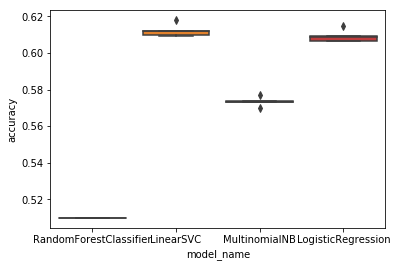

In [70]:
print dfCV
sns.boxplot(x='model_name', y='accuracy', data=dfCV)

#                 model_name  fold_idx  accuracy
# 0   RandomForestClassifier         0  0.509879
# 1   RandomForestClassifier         1  0.509880
# 2   RandomForestClassifier         2  0.509947
# 3   RandomForestClassifier         3  0.509947
# 4   RandomForestClassifier         4  0.509930
# 5                LinearSVC         0  0.617839
# 6                LinearSVC         1  0.612021
# 7                LinearSVC         2  0.609348
# 8                LinearSVC         3  0.609679
# 9                LinearSVC         4  0.612248
# 10           MultinomialNB         0  0.576833
# 11           MultinomialNB         1  0.573098
# 12           MultinomialNB         2  0.573533
# 13           MultinomialNB         3  0.569991
# 14           MultinomialNB         4  0.573320
# 15      LogisticRegression         0  0.614529
# 16      LogisticRegression         1  0.608480
# 17      LogisticRegression         2  0.606567
# 18      LogisticRegression         3  0.606369
# 19      LogisticRegression         4  0.609037

<H2>Tune the SVC Model</H2>

Commented out as long running--best results in comments.

In [71]:
# clfSVC = Pipeline([('vect', CountVectorizer(max_df = 0.3, ngram_range= (1,3), stop_words='english')),
#                      ('tfidf', TfidfTransformer(use_idf = False)),
#                      ('clfSVC', LinearSVC(),)
                                                       
# ])
# clfSVC = clfSVC.fit(trainLines, trainSents)

# parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
#                'vect__max_df': (0.3,0.4,0.5,0.6),  
#                'tfidf__use_idf': (True, False),
#                'clfSVC__loss': ('hinge', 'squared_hinge'),
#                 'clfSVC__C': (0.5,0.75,1.0),}                             

# gsSVC = GridSearchCV(clfSVC, parameters, n_jobs=6)
# gsSVC = gsSVC.fit(trainLines, trainSents)

In [72]:
# print gsSVC.best_score_
# gsSVC.best_params_

# 0.6542565867867073
# {'clfSVC__C': 0.5,
#  'clfSVC__loss': 'squared_hinge',
#  'tfidf__use_idf': False,
#  'vect__max_df': 0.3,
#  'vect__ngram_range': (1, 2)}

0.6542565867867073


{'clfSVC__C': 0.5,
 'clfSVC__loss': 'squared_hinge',
 'tfidf__use_idf': False,
 'vect__max_df': 0.3,
 'vect__ngram_range': (1, 2)}

In [15]:
clfSVC = Pipeline([('vect', CountVectorizer(max_df = 0.5, ngram_range= (1,2), stop_words='english')),
                     ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clfSVC', LinearSVC(loss='squared_hinge', C=0.5),)
                                                       
])

dfTxt, lines, sents = LoadData('train')
allLines = StemWords('snowball', lines)
allLines = MarkNegative(allLines)
trainLines, testLines, trainSents, testSents = CreateTrainTestData(allLines, len(allLines), 5000)

clfSVC = clfSVC.fit(trainLines, trainSents)

predicted = clfSVC.predict(testLines)

print np.mean(predicted == testSents)
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))

0.6596
             precision    recall  f1-score   support

          0       0.48      0.34      0.40       231
          1       0.59      0.49      0.54       901
          2       0.72      0.84      0.78      2553
          3       0.58      0.51      0.54      1045
          4       0.53      0.36      0.43       270

avg / total       0.65      0.66      0.65      5000



<H2>Stop Words</H2>

One thing not yet tried is not using the "stopwords" param.  This takes out some commone words from the modeling (a, the, you, etc.) that generally wouldn't affect results of sentiment analysis.  But the way this data set is structured there are lot of one or two word lines to be analyzed, and some of the involve these stopwords.  So below we take it out, and see that we actually improve 1% to almost 67% accuracy, our best score yet.

In [14]:
clfSVC = Pipeline([('vect', CountVectorizer(max_df = 0.5, ngram_range= (1,2))),
                     ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clfSVC', LinearSVC(loss='squared_hinge', C=0.5),)
                                                       
])

clfSVC = clfSVC.fit(trainLines, trainSents)

predicted = clfSVC.predict(testLines)

print np.mean(predicted == testSents)
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))

0.6696
             precision    recall  f1-score   support

          0       0.52      0.36      0.43       231
          1       0.61      0.50      0.55       901
          2       0.73      0.85      0.78      2553
          3       0.59      0.52      0.55      1045
          4       0.56      0.37      0.44       270

avg / total       0.66      0.67      0.66      5000



<H2>Further Examination, Confusion Matrix</H2>

So we are 67%, but if we look at the classification report above, we see we do quite well comparatively to 2 or neutral sentiments, but we get noticably worse results as we move away from neutral.  

So, let's dig a little deeper, using a confusion matrix heat map to see in better detail where the classifier has gone wrong.  With this while results are still not great, they actually look <b>much better</b>.  We are not classifying things that are really negative as really positive or vice-versa; mostly we are off by 1 classifier, e.g., something that should have been a 2 was predicted as 3, something that should have been a 1 was predicted as a 2.  Very few things were off by more than 1 (the heatmap was quite 'cold' for such cells).  The diagonal of the heat map is much hotter than the away from it, which is what we want.

The other thing to note, is that for the most part we are underpredicting away from a neutral sentiment (2).  That is we prediced a 2, when it should have been a 1 or 3.  

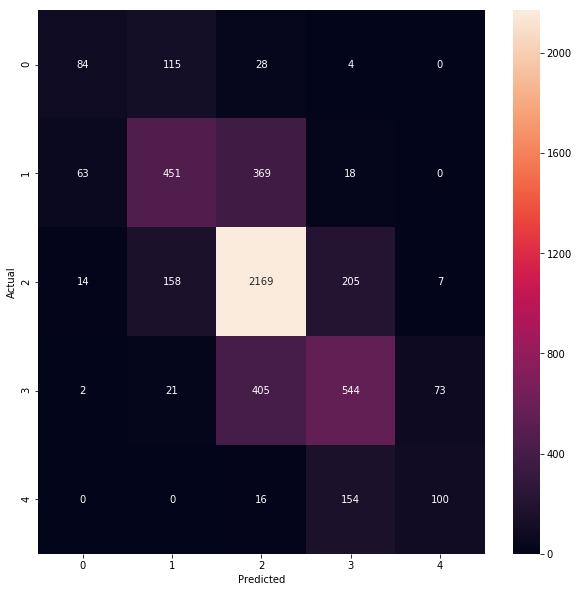

In [15]:
conf_mat = confusion_matrix(testSents, predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<H2>Examination of Rows in Error</H2>

Below are all the test rows where the predicted value does not match.  What is interesting, is some of the actual prediction values seem (in my mind) to be erroneous in of themselves.  For example, 153214, often fabul (which is likley stemmed from often fabulous) seems postive, and was predicted as such, yet the score was neutral at a 2.  Or more extreme, 153401, "it visual hideous" was scored a neutral 2, but is seems pretty negative and the prediction was 0.  

So, it is possible some of the lack of success is due to items like that.

In [20]:
import qgrid
dfResults =  pd.DataFrame(data = {'sentence' : testLines , 'value': testSents.values, 'prediction': predicted})
dfResults =  dfResults[['sentence', 'value', 'prediction'] ]
dfResults['dif'] = dfResults.value - dfResults.prediction

q = qgrid.show_grid(dfResults[dfResults.dif <> 0].sort_values(by='dif'), show_toolbar=False)
q
          


UWdyaWRXaWRnZXQoZ3JpZF9vcHRpb25zPXsnaGlnaGxpZ2h0U2VsZWN0ZWRSb3cnOiBUcnVlLCAnZnVsbFdpZHRoUm93cyc6IFRydWUsICdyb3dIZWlnaHQnOiAyOCwgJ2VuYWJsZUNvbHVtblLigKY=


<H2>NLTK Sentiment Intensity Analyzer</H2>
One thought is that are learning methods above are using just supervised learning without any obvious knowledge of what words "mean".  So a consideration was done to use the SentimentIntensityAnalyzer which has a dictionary of words and their inherent postiveness or negativeness.  Since many predictions were off by one degree, the hope was that perhaps by adjusting predictions up or down for sentences that have high postiveness or negativeness, we could improve the accuracy a little bit.

NLTK has a SentimentIntensityAnalyzer, perhaps by using this we can "adjust" scores a little bit for some that might be on the border, e.g., see that a 3 should really be a 2, b/c there is some negative phrasing in the sentence.

Overall, results were worse, an example run is below, with adjusted scores.  A grid of results show how things were adjusted, and some were certainly adjusted in the right direction, others were then adjusted in the wrong direction.  Since we were able to improve things, it is possible that a more complex algorithm using this analyzer could return better results, but we will not use it for this project.

In [29]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

adjScores = []
polaritys = []
for idx, row in dfResults.iterrows():    
    polarity = sid.polarity_scores(row.sentence)['pos'] - sid.polarity_scores(row.sentence)['neg'] 
    
    if (float(polarity) > 0.6) and (row.prediction < 4):
        adjScore = row.prediction + 1
    elif (polarity < -1.6) and (row.prediction >0):
        adjScore = row.prediction - 1        
    else:
         adjScore = row.prediction
    adjScores.append(adjScore)
    
    
    
        
dfResults['adjScore'] = adjScores
dfResults['adjDif'] = dfResults.value - dfResults.adjScore
dfResults['adjFromPred'] = dfResults.prediction - dfResults.adjScore
print(metrics.classification_report(testSents, dfResults.adjScore, target_names=['0','1','2','3','4'] ))
dfResults[dfResults.adjFromPred <> 0].sort_values(by='adjFromPred')
    
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\todddesktop\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


             precision    recall  f1-score   support

          0       0.52      0.36      0.43       231
          1       0.61      0.50      0.55       901
          2       0.73      0.83      0.77      2553
          3       0.55      0.48      0.51      1045
          4       0.42      0.43      0.42       270

avg / total       0.64      0.65      0.64      5000



,sentence,value,prediction,dif,adjScore,adjDif,adjFromPred
151091,fair dispos,0,1,-1,2,-2,-1
154371,recommend,3,3,0,4,-1,-1
154446,the rich perform,3,3,0,4,-1,-1
154531,", comic relief",2,3,-1,4,-2,-1
154563,reason attract holiday contrapt,3,3,0,4,-1,-1
154576,enjoy the film,3,3,0,4,-1,-1
154601,a strong messag,3,3,0,4,-1,-1
154620,scoop,2,2,0,3,-1,-1
154363,the gift,2,2,0,3,-1,-1
154633,a strong case,3,3,0,4,-1,-1


<H2>Probabilities</H2>

One last thing tried is adjusting classification based on probabilities.  The theory is that perhaps if we examing probabilities algorithmically, we can tweak some scores up or down.  

Since SVC doesn't support returning probabilities we will use the next best classifier from when we examined which performed best for this data, this would be just logistic regression.

So first we will use GridSearch to optimize parameters (again commented out) to find the best hyperparameters.

In [30]:
# trainLines, testLines, trainSents, testSents = CreateTrainTestData(allLines, 25000, 5000)
# clfLog = Pipeline([('vect', CountVectorizer(stop_words='english')),
#                      ('tfidf', TfidfTransformer()),
#                      ('clfLog', LogisticRegression(random_state=42,multi_class='multinomial', solver = 'lbfgs'))
                                                       
# ])
# clfLog = clfLog.fit(trainLines, trainSents)

# parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3), (1,4)],
#                'vect__max_df': (0.2, 0.3, 0.4, 0.5, 0.6),  
#                'tfidf__use_idf': (True, False),                             
#                'clfLog__C': (0.25, 0.5, 0.75, 1.0,1.5,2.0,2.5,3.0),}               
#                #'clfLog__penalty': ('l1', 'l2'),              

# gsLog = GridSearchCV(clfLog, parameters, n_jobs=6)
# gsLog = gsLog.fit(trainLines, trainSents)

In [32]:
# print gsLog.best_score_
# gsLog.best_params_

# 0.5711
# {'clfLog__C': 2.0,
#  'tfidf__use_idf': False,
#  'vect__max_df': 0.2,
#  'vect__ngram_range': (1, 2)}

0.5711


{'clfLog__C': 2.0,
 'tfidf__use_idf': False,
 'vect__max_df': 0.2,
 'vect__ngram_range': (1, 2)}

<H2>Results of Tuning Logistic Regression Classifier</H2>

0.638
             precision    recall  f1-score   support

          0       0.54      0.20      0.29       231
          1       0.55      0.38      0.45       901
          2       0.68      0.87      0.76      2553
          3       0.57      0.49      0.52      1045
          4       0.55      0.25      0.34       270

avg / total       0.62      0.64      0.61      5000

0  231  85
1  901  626
2  2553  3273
3  1045  894
4  270  122


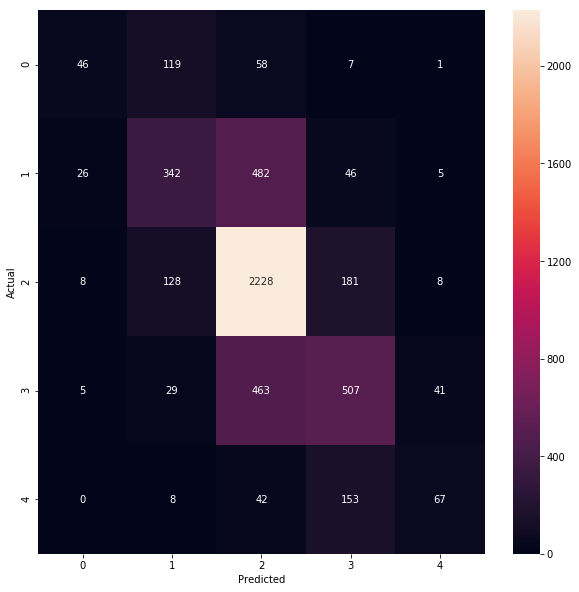

In [33]:
trainLines, testLines, trainSents, testSents = CreateTrainTestData(allLines, len(allLines), 5000)


clfLog = Pipeline([('vect', CountVectorizer(max_df = 0.2, ngram_range=(1,1))), # stop_words='english')),  #stopwords reduces accuracy
                     ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clfLog', LogisticRegression(random_state=42, C=1.0, penalty= 'l2', multi_class='multinomial', solver = 'lbfgs')),                                                      
])
clfLog = clfLog.fit(trainLines, trainSents)
predicted = clfLog.predict(testLines)
print np.mean(predicted == testSents)
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))

for sent in [0,1,2,3,4]:
    print str(sent) + '  ' + str(len(testSents[testSents == sent])) + '  ' + str(len(predicted[predicted == sent]))
    
conf_mat = confusion_matrix(testSents, predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()    

<H2>Examination of the Probabilities</H2>


In [34]:
predProb = clfLog.predict_proba(testLines)
predProb

dfPred = pd.DataFrame(predProb)
dfPred['Predicted'] = predicted
dfPred['Actual'] = np.asarray(testSents)


dfPred.columns = ['S0', 'S1', 'S2', 'S3', 'S4', 'Predicted', 'Actual'  ]
dfPredOrig = dfPred.copy()
dfPred[(dfPred.Predicted <> dfPred.Actual) & (dfPred['S2'] < 0.5)]

,S0,S1,S2,S3,S4,Predicted,Actual
5,0.118147,0.518538,0.285241,0.069166,0.008908,1,0
11,0.036718,0.454517,0.455057,0.047592,0.006115,2,1
13,0.032162,0.090215,0.049909,0.638608,0.189106,3,1
15,0.312194,0.245238,0.188039,0.237662,0.016867,0,1
16,0.589895,0.241050,0.040270,0.076306,0.052478,0,1
19,0.020464,0.776658,0.166270,0.031096,0.005512,1,2
31,0.014471,0.614247,0.256727,0.109273,0.005283,1,0
41,0.059794,0.388727,0.411893,0.118428,0.021158,2,1
51,0.027514,0.378940,0.408803,0.157104,0.027640,2,3
56,0.014452,0.075523,0.163581,0.552557,0.193887,3,4


<H2>Results of Tweaking Predictions Based on Probability</H2>
While playing with it a little bit we were able to increase the score about a quarter of a percent.  Not much but interesting nonetheless.  Regardless, these scores are still less than just using the SVC method and even with more tweaking to adjust items at 1 or 3 probabilites (the next most mislabled predictions) it is unlikely we will best that method.

In [ ]:
dfPred = dfPredOrig.copy()

for i in range(len(dfPred)):
#     if (dfPred.Predicted[i] == 2) & (((dfPred.at[i,'S3'] + dfPred.at[i,'S4']) -.15  ) > dfPred.at[i,'S2']):        
#         dfPred.at[i, 'Predicted'] = 3    
    if (dfPred.Predicted[i] == 2) & (((dfPred.at[i,'S0'] + dfPred.at[i,'S1']) +.15  ) > dfPred.at[i,'S2']):            
        dfPred.at[i, 'Predicted'] = 1
        
print np.mean(dfPred.Predicted == dfPred.Actual)
print(metrics.classification_report(dfPred.Actual, dfPred.Predicted, target_names=['0','1','2','3','4'] ))
            
for sent in [0,1,2,3,4]:
    print str(sent) + '  ' + str(len(dfPred.Actual[dfPred.Actual == sent])) + '  ' + str(len(dfPred.Predicted[dfPred.Predicted == sent]))
    
conf_mat = confusion_matrix(dfPred.Actual, dfPred.Predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()   

<H2>Running without lowercasing the text</H2>
Initially we had lowercased all the text, so as to improve performance as we tested.  Before we are completely done, we will instead run the SVC classifier with the unadultered capitalization to get the best possible results.  It seems likely that there are cases were text is capitalized for emphasis, which could adjust sentiment.  A

In doing this we see that we got about 1% more accuracy out of the model.  So it does indeed improve things.

In [71]:
dfTxt, lines, sents = LoadData('train', False)
allLines = StemWords('snowball', lines)
allLines = MarkNegative(allLines)
trainLines, testLines, trainSents, testSents = CreateTrainTestData(allLines, len(allLines), 5000)

clfSVC = Pipeline([('vect', CountVectorizer(max_df = 0.5, ngram_range= (1,2))),
                     ('tfidf', TfidfTransformer(use_idf = False)),
                     ('clfSVC', LinearSVC(loss='squared_hinge', C=0.5),)
                                                       
])

clfSVC = clfSVC.fit(trainLines, trainSents)

predicted = clfSVC.predict(testLines)

print np.mean(predicted == testSents)
print(metrics.classification_report(testSents, predicted, target_names=['0','1','2','3','4'] ))


# 0.6696
#              precision    recall  f1-score   support

#           0       0.52      0.36      0.43       231
#           1       0.61      0.50      0.55       901
#           2       0.73      0.85      0.78      2553
#           3       0.59      0.52      0.55      1045
#           4       0.56      0.37      0.44       270

# avg / total       0.66      0.67      0.66      5000

0.6696
             precision    recall  f1-score   support

          0       0.52      0.36      0.43       231
          1       0.61      0.50      0.55       901
          2       0.73      0.85      0.78      2553
          3       0.59      0.52      0.55      1045
          4       0.56      0.37      0.44       270

avg / total       0.66      0.67      0.66      5000



<H2>Submit on Kaggle, See how we did,</H2>
The below will run the training on the whole train dataset (rather than most of it, since some was split of to evaluate for training).  It will then create a submission file for Kaggle.

In [78]:

#retrain on the whole set of data, rather than the slightly incomplete set that reserved some for testing
dfTxt, lines, sents = LoadData('train', False)
allLines = StemWords('snowball', lines)
allLines = MarkNegative(allLines)
clfSVC = clfSVC.fit(allLines, dfTxt.Sentiment)
#clfNB = clfNB.fit(allLines, dfTxt.Sentiment)

dfTest, lines, sents = LoadData('test', False)
allLines = StemWords('snowball', lines)
allLines = MarkNegative(allLines)


predicted = clfSVC.predict(allLines)
dfTest['Sentiment']  = predicted


dfSubmission = dfTest[['PhraseId', 'Sentiment']]
dfSubmission.to_csv('moviesentiment/submission.csv', sep = ',', index=False)

<H2>Results</H2>
<img src="moviesentiment/kaggleSubmission.PNG">
Our score was about 63%, which was less than what we tested with.  So slightly disappointing, it may mean we overfitted some and should have worked more to address that.

<H2>Comparison to Others</H2>
If we compare our results to others we see our score of 0.63277, would have finished 224 out of 861, which is about at the 25% percentile from the top.  Also if looking at the complete leaderboard, only 5 people finished at 0.68 or higher.   So overall not too bad.  (Note because the competition is old, and closed, my submission did not get put onto the leaderboard)

<img src="moviesentiment/kaggleLeaderBoard.PNG">